In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, ops
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from tqdm import tqdm
import numpy as np


In [2]:
BATCH_SIZE = 32
NUM_OF_WORKERS = 2
NUM_OF_EPOCHS = 40

trainset = datasets.FashionMNIST('data_original/', download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_OF_WORKERS)
testset = datasets.FashionMNIST('data_original/', download=True, train=False, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_OF_WORKERS)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(torch.cuda.get_device_name(0))

NVIDIA GeForce GTX 1060 6GB


In [4]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

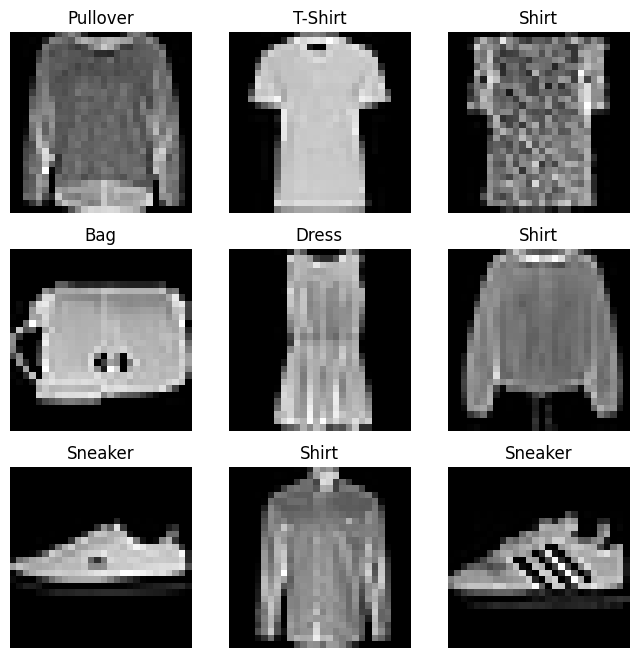

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
# PyTorch models inherit from torch.nn.Module
class GarmentClassifierDeform(nn.Module):
    def __init__(self):
        super(GarmentClassifierDeform, self).__init__()
        self.conv1 = ops.DeformConv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = ops.DeformConv2d(6,16,5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x,offset1)))
        x = self.pool(F.relu(self.conv2(x,offset2)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

earlystopper_deform = EarlyStopper(min_delta = 0, patience =3)

model_deform = GarmentClassifierDeform()

offset1 = torch.rand(BATCH_SIZE, 2 * 5 * 5, 24,24)
offset2 = torch.rand(BATCH_SIZE, 2 * 5 * 5, 8,8)
offset1.to(device)
offset2.to(device)
model_deform.to(device)


GarmentClassifierDeform(
  (conv1): DeformConv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): DeformConv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
deform_batch_tr_loss = {}
deform_batch_te_loss = {}

deform_best_test_loss = float('inf')

loss_fn_deform = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deform.parameters(), lr=0.001)

# epoch loss and accuracy
tr_loss_deform, tr_acc_deform = [], []
te_loss_deform, te_acc_deform = [], []

for t in (range(NUM_OF_EPOCHS)):
    model_deform.train()
    batch_loss, batch_accuracy = [], []
    print(f"Epoch {t+1} Training...")
    for X,y in tqdm(trainloader):
        X = X.to(device)
        y = y.to(device)
        predicted = model_deform(X)
        loss = loss_fn_deform(predicted, y)
        batch_accuracy.append(float(torch.argmax(predicted, dim=1).eq(y).sum().item()/len(y)))
        batch_loss.append(float(loss.item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    batches = len(batch_loss)
    tr_loss_deform.append(sum(batch_loss)/batches)
    tr_acc_deform.append(sum(batch_accuracy)/batches)

    model_deform.eval()
    with torch.no_grad():
        batch_loss, batch_accuracy = [], []
        print(f"Epoch {t+1} Testing...")
        for X,y in tqdm(testloader):
            X = X.to(device)
            y = y.to(device)
            predicted = model_deform(X)
            loss = loss_fn_deform(predicted, y)
            batch_accuracy.append(float(torch.argmax(predicted, dim=1).eq(y).sum().item()/len(y)))
            batch_loss.append(float(loss.item()))

        batches = len(batch_loss)
        te_loss_deform.append(sum(batch_loss)/batches)
        te_acc_deform.append(sum(batch_accuracy)/batches)

    # Save the model_deform's weights after each epoch
    torch.save(model_deform.state_dict(), f"model_deform_weights/{BATCH_SIZE}_model_deform_weights.pth")

    # Check if the current test loss is the best so far
    if te_loss_deform[-1] < best_test_loss:
        best_test_loss = te_loss_deform[-1]
        # Save the model_deform's weights with the best test loss
        torch.save(model_deform.state_dict(), f"model_deform_weights/{BATCH_SIZE}_best_model_deform_weights.pth")

    if earlystopper.early_stop(te_loss_deform[-1]):
      print(f"Early Stop at {t+1} epochs.")
      print(f"Epoch {t+1}: Train_accuracy: {(100*tr_acc_deform[-1]):>0.2f}%, Train_loss: {tr_loss_deform[-1]:>8f}, Test_accuracy: {(100*te_acc_deform[-1]):>0.2f}%, Test_loss: {te_loss_deform[-1]:>8f}")
      break

    print(f"Epoch {t+1}: Train_accuracy: {(100*tr_acc_deform[-1]):>0.2f}%, Train_loss: {tr_loss_deform[-1]:>8f}, Test_accuracy: {(100*te_acc_deform[-1]):>0.2f}%, Test_loss: {te_loss_deform[-1]:>8f}")


Epoch 1 Training...


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:04<?, ?it/s]


RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`